# Read in the data

In [2]:
import pandas as pd
import numpy as np
import re

data_files = ["ap_2010.csv",
              "class_size.csv",
              "demographics.csv",
              "graduation.csv",
              "hs_directory.csv",
              "sat_results.csv"]
data = {}

for f in data_files:
    d = pd.read_csv("../data/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("../data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("../data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations = correlations.dropna()
correlations.sort_values(ascending=False, inplace=True)

# Interesting correlations tend to have r value > .25 or < -.25
interesting_correlations = correlations[abs(correlations) > 0.25]
print(interesting_correlations)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

In [12]:
# Setup Matplotlib to work in Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Survey Correlations

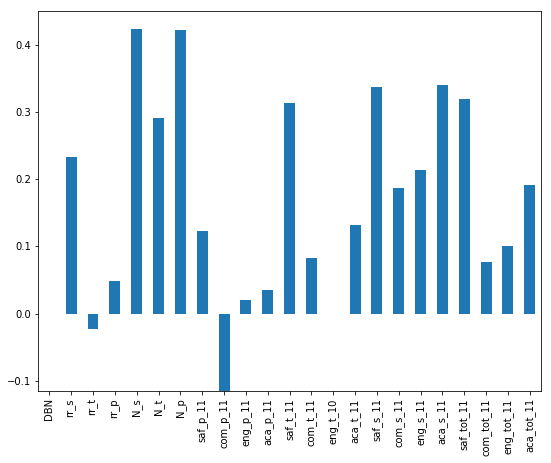

In [13]:
# Make a bar plot of the correlations between survey fields and sat_score
correlations[survey_fields].plot.bar(figsize=(9,7))

From the survey fields, two stand out due to their significant positive correlations:
* N_s - Number of student respondents
* N_p - Number of parent respondents
* aca_s_11 - Academic expectations score based on student responses
* saf_s_11 - Safety and Respect score based on student responses

Why are some possible reasons that N_s and N_p could matter?
1. Higher numbers of students and parents responding to the survey may be an indicator that students and parents care more about the school and about academics in general.
1. Maybe larger schools do better on the SAT and higher numbers of respondents is just indicative of a larger overall student population.
1. Maybe there is a hidden underlying correlation, say that rich students/parents or white students/parents are more likely to both respond to surveys and to have the students do well on the SAT.
1. Maybe parents who care more will fill out the surveys and get their kids to fill out the surveys and these same parents will push their kids to study for the SAT.

# Safety and SAT Scores
Both student and teacher perception of safety and respect at school correlate significantly with SAT scores.  Let's dig more into this relationship.

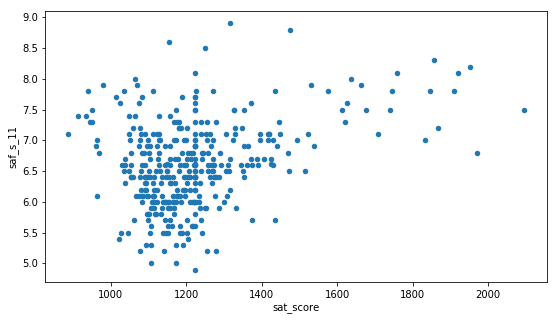

In [14]:
# Make a scatterplot of the saf_s_11 column vs the sat-score in combined
combined.plot.scatter(x='sat_score', y='saf_s_11', figsize=(9,5))

So a high saf_s_11 student safety and respect score doesn't really have any predictive value regarding SAT score.  However, a low saf_s_11 has a very strong correlation with low SAT scores.

## Map out Safety Scores

In [15]:
# Find the average values for each column for each school_dist in combined
districts = combined.groupby('school_dist').agg(np.mean)

# Reset the index of districts, making school_dist a column again
districts.reset_index(inplace=True)

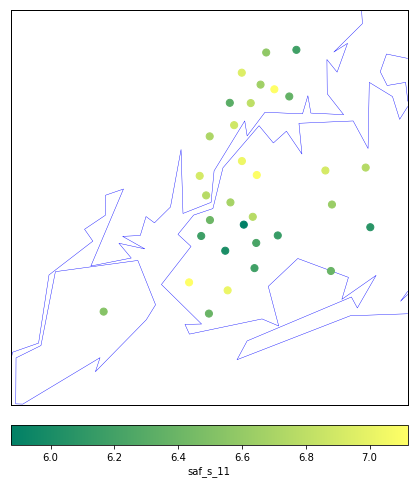

In [16]:
# Make a map that shows afety scores by district
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(8,8))
# Setup the Matplotlib Basemap centered on New York City
m = Basemap(projection='merc',
            llcrnrlat=40.496044,
            urcrnrlat=40.915256,
            llcrnrlon=-74.255735,
            urcrnrlon=-73.700272,
            resolution='i')
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='blue', linewidth=.4)
m.drawrivers(color='blue', linewidth=.4)

# Convert the lat and lon columns of districts to lists
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

# Plot the locations
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, 
          c=districts['saf_s_11'], cmap='summer')

# Add colorbar
# add colorbar.
cbar = m.colorbar(location='bottom',pad="5%")
cbar.set_label('saf_s_11')

So it looks like the safest schools are in Manhattan, while the least safe schools are in Brooklyn.

This jives with [crime statistics by borough](http://data.newsday.com/long-island/data/crime/new-york-city-crime-rate/) 

# Race and SAT Scores
There are a few columsn that indicate the percentage of each race at a given school:
* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can see if there are any racial differences in SAT performance.

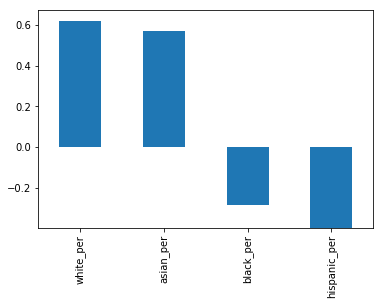

In [17]:
# Make a plot of the correlations between racial cols and sat_score
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_corr = correlations[race_cols]
race_corr.plot(kind='bar')

A higher percentage of white and asian students correlates positively with SAT scores and a higher percentage of black or hispanic students correlates negatively with SAT scores.  I wouldn't say any of this is suprising.  My guess would be that there is an underlying economic factor which is the cause - white and asian neighborhoods probably have a higher median household income and more well funded schools than black or hispanic neighborhoods.

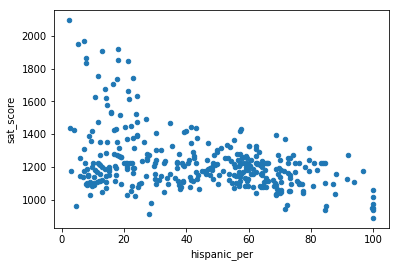

In [18]:
# Explore schools with low SAT scores and a high hispanic_per
combined.plot.scatter(x='hispanic_per', y='sat_score')

The above scatterplot shows that a low hispanic percentage isn't particularly predictive of SAT score.  However, a high hispanic percentage is highly predictive of a low SAT score.

In [19]:
# Research any schools with a greater than 95% hispanic_per
high_hispanic = combined[combined['hispanic_per'] > 95]

# Find the names of schools from the data
high_hispanic['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The above schools appear to contain a lot of international schools focused  on recent immigrants who are learning English as a 2nd language.  It makes sense that they would have a harder time on the SAT which is given soley in English.

In [20]:
# Research any schools with less than 10% hispanic_per and greater than
# 1800 average SAT score
high_sat_low_hispanic = combined[(combined['hispanic_per'] < 10) & 
                                 (combined['sat_score'] > 1800)]
high_sat_low_hispanic['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of the schools above appear to be specialized science and technology schools which receive extra funding and require students to do well on a standardized test before being admitted.  So it is reasonable that students at these schools would have a high average SAT score.

# Gender and SAT Scores
There are two columns that indicate the percentage of each gender at a school:
* male_per
* female_per

In [21]:
# Investigate gender differences in SAT scores
gender_cols = ['male_per', 'female_per']
gender_corr = correlations[gender_cols]
gender_corr

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

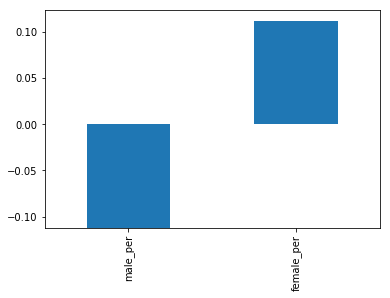

In [22]:
# Make a plot of the gender correlations
gender_corr.plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

More data would be required before I was wiling to say that this is a significant effect.

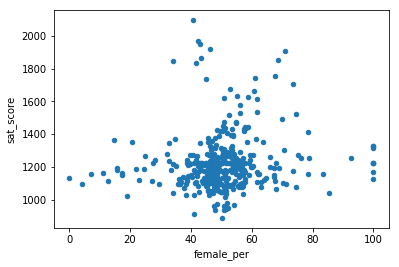

In [23]:
# Investigate schools with high SAT scores and a high female_per
combined.plot.scatter(x='female_per', y='sat_score')

The above plot appears to show that either very low or very high percentage of females in a school leads to a low average SAT score.  However, a percentage in the range 40 to 80 or so can lead to good scores.  There doesn't appear to be a strong overall correlation.

In [24]:
# Research any schools with a greater than 60% female_per, and greater
# than 1700 average SAT score.
high_female_high_sat = combined[(combined['female_per'] > 60) &
                                (combined['sat_score'] > 1700)]
high_female_high_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

# AP Scores vs SAT Scores
The Advanced Placement (AP) exams are exams that high schoolers take in order to gain college credit.  AP exams can be taken in many different subjects, and passing the AP exam means that colleges may grant you credits.

It makes sense that the number of students who took the AP exam in a school and SAT scores would be highly correlated.  Let's dig into this relationship more.

Since total_enrollment is highly correlated with sat_score, we don't want to bias our results, so we'll instead look at the percentage of students in each school who took at least one AP exam.

In [25]:
# Compute the percentage of students in each school that took the AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

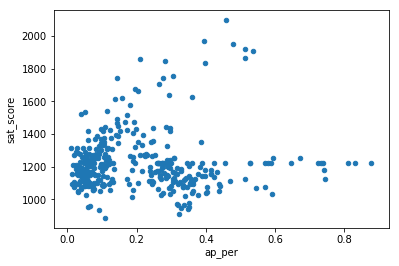

In [26]:
# Investigate the relationship between AP scores and SAT scores
combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

I"m really surprised this relationship isn't stronger.  This is rather counter-intuitive.

# Next Steps
There is still quite a bit of analysis left to do.  Here are some potential next steps
* Look at free and reduced lunch percentage and SAT scores
  * Combine current dataset with a median household income by school district dataset to see how that correlates (if we can find one)
* Looking at class size and SAT scores
* Figuring out the best area to live in based on school performance
  * If we combine this with a property values dataset, we could find the cheapest place where there are good schools
* Looking into the differences between parent, teacher, and student responses to surveys
* Assigning a score to schools based on sat_score and other attributes